# ViT Paper Replicating using PyTorch
By: Javier H.

Replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010.11929

Specifically, we are replicating the ViT-B/16 model.

This Google Colab notebook goes in depth about how the ViT architecture was replicated in PyTorch.

## Imports and Setup

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torchvision
from torchinfo import summary

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os
import zipfile
import requests

import random
from tqdm.auto import tqdm
from pathlib import Path
from shutil import copy

In [ ]:
print(torch.__version__, torchvision.__version__)

2.9.0+cu126 0.24.0+cu126


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
if device == "cuda":
    !nvidia-smi

Thu Jan  1 00:17:55 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             14W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Worker Functions

In [ ]:
def train_test_split_folders(data_dir, train_dir, test_dir, split_ratio=0.8):
    """
    Splits the data into train and test folders so that DataLoaders can use them
    """
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)

    for cls in data_dir.iterdir():
        if cls.is_dir():
            images = list(cls.iterdir())
            random.shuffle(images)
            split_idx = int(split_ratio * len(images))

            cls_train = train_dir / cls.name
            cls_test = test_dir / cls.name
            cls_train.mkdir(exist_ok=True)
            cls_test.mkdir(exist_ok=True)

            for img in images[:split_idx]:
                copy(img, cls_train / img.name)
            for img in images[split_idx:]:
                copy(img, cls_test / img.name)

In [ ]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    """
    Creates training and testing DataLoaders.

    Takes in a training directory and testing directory path and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.
    """

    # Use ImageFolder to create datasets
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> tuple[float, float]:
    """
    Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).
    """

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> tuple[float, float]:
    """
    Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.
    """

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> dict[str, list]:
    """
    Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.
    """

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """
    Saves a PyTorch model to a target directory.
    """

    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

## Helper Functions

In [ ]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    """

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """
    Plots decision boundaries of model predicting on X in comparison to y.
    """

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [ ]:
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
    Plots linear training data and test data and compares predictions.
    """

    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

In [ ]:
def accuracy_fn(y_true, y_pred):
    """
    Calculates accuracy between truth labels and predictions.
    """

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def print_train_time(start, end, device=None):
    """
    Prints difference between start and end time.
    """

    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
def plot_loss_curves(results):
    """
    Plots training curves of a results dictionary.
    """

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [ ]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: list[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """
    Makes a prediction on a target image with a trained model and plots the image.
    """

    # 1. Load in image and convert the tensor values to float32
    # target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    # target_image = target_image / 255.0

    # 1&2. Loading in via PIL as sometimes transforms have ToTensor() and expect PIL or ndarray
    target_image = Image.open(image_path).convert("RGB")

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Add an extra dimension to the image
    target_image = target_image.unsqueeze(dim=0)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)


In [ ]:
def set_seeds(seed: int=42):
    """
    Sets random sets for torch operations.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [ ]:
def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """
    Downloads a zipped dataset from source and unzips to destination.
    """
    # Setup path to data folder
    data_path = Path("/content/data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

In [ ]:
def download_image(source: str, dest: str) -> Path:
    dest_path = Path(dest)
    dest_path.parent.mkdir(parents=True, exist_ok=True)

    if not dest_path.is_file():
        request = requests.get(source)
        request.raise_for_status()
        print(f"Downloading {dest_path}...")
        dest_path.write_bytes(request.content)
    else:
        print(f"{dest_path} already exists, skipping download.")

    return dest_path

## Weather Image Data
Weather image data from Kaggle will be used to test the ViT model architecture.

*Note:* The results will be poorer than expected as it is not pretrained on large datasets such as ImageNet (unlike PyTorch's built in ViT model)

In [ ]:
import kagglehub
path = kagglehub.dataset_download("ammaralfaifi/5class-weather-status-image-classification")

100%|██████████| 498M/498M [00:24<00:00, 21.6MB/s]

Extracting files...


In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ammaralfaifi/5class-weather-status-image-classification/versions/1


In [ ]:
walk_through_dir(path)

There are 1 directories and 0 images in '/root/.cache/kagglehub/datasets/ammaralfaifi/5class-weather-status-image-classification/versions/1'.
There are 5 directories and 0 images in '/root/.cache/kagglehub/datasets/ammaralfaifi/5class-weather-status-image-classification/versions/1/data'.
There are 0 directories and 1875 images in '/root/.cache/kagglehub/datasets/ammaralfaifi/5class-weather-status-image-classification/versions/1/data/snowy'.
There are 0 directories and 1927 images in '/root/.cache/kagglehub/datasets/ammaralfaifi/5class-weather-status-image-classification/versions/1/data/rainy'.
There are 0 directories and 6274 images in '/root/.cache/kagglehub/datasets/ammaralfaifi/5class-weather-status-image-classification/versions/1/data/sunny'.
There are 0 directories and 1261 images in '/root/.cache/kagglehub/datasets/ammaralfaifi/5class-weather-status-image-classification/versions/1/data/foggy'.
There are 0 directories and 6702 images in '/root/.cache/kagglehub/datasets/ammaralfaif

In [ ]:
data_dir = Path(path) / "data"
train_dir = Path("/content/weather/train")
test_dir = Path("/content/weather/test")

In [ ]:
train_test_split_folders(data_dir=data_dir, train_dir=train_dir, test_dir=test_dir)

In [ ]:
IMG_SIZE = 224 # Table 3 from ViT paper

# transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [ ]:
BATCH_SIZE = 32

# creating DataLoaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(4))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

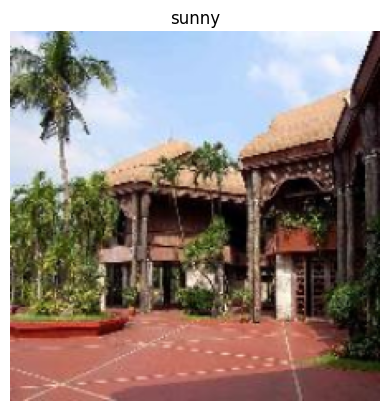

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

## Replicating the ViT

**Figure 1**
![](https://raw.githubusercontent.com/JavRedstone/vit-architecture-pytorch/refs/heads/main/paper/vit-paper-figure-1-architecture-overview.png)

**Equations**
![](https://raw.githubusercontent.com/JavRedstone/vit-architecture-pytorch/refs/heads/main/paper/vit-paper-four-equations.png)

1. Patch embeddings
2. Multi-Head Self-Attention (MSA) block
3. Multi-Layer Perceptron (MLP) block
4. Layer Normalization (LN)

A classification token $x_{\text{class}}$ is prepended to the patch embeddings, and positional embeddings $E_{\text{pos}}$ are added.

$E_{\text{pos}}$ is a learnable matrix that injects spatial position information for the class token and each image patch by elementwise addition to the input embeddings.

```python
# Equation 1
z_0 = [x_class, image_patch_1, image_patch_2, ..., image_patch_N] + E_pos
```

Each Transformer encoder layer uses pre-layer normalization and residual connections.

```python
# Equation 2 (MSA block)
z_l_prime = MSA_layer(LN_layer(z_{l-1})) + z_{l-1}
```

```python
# Equation 3 (MLP block)
z_l = MLP_layer(LN_layer(z_l_prime)) + z_l_prime
```

After the final Transformer layer, the class token (prepended so 0th index) is used for classification.

```python
# Equation 4 (classification head)
y = Linear_layer(LN_layer(z_L[0]))
```

**Table 1**
![](https://raw.githubusercontent.com/JavRedstone/vit-architecture-pytorch/refs/heads/main/paper/vit-paper-table-1.png)

- Layers: Number of transformer encoder layers
- Hidden size $D$: Embedding size
- MLP size: Number of hidden units in the MLP
- Head: Number of MSA

## Equation 1: Splitting into patches, and creating patch embeddings with the class token and position embeddings

*Note: We have color channels written first due to PyTorch's notation*

- Input Shape: $C \times H \times W \rightarrow (C, H, W) = (3, 224, 224)$
- Output Shape: $N \times (C \cdot P^2) \rightarrow (N, C \cdot P^2)$

- $C$: Number of channels
- $H$: Height
- $W$: Width
- $P$: Height and width (patch size) of each image patch, resolution being $(P, P)$, so dimensions of each patch is $(C, P, P)$
- $N = \frac{H \cdot W}{P^2}$ is the number of patches and the effective input sequence length to the Transformer
- $D$: Constant latent vector size which is the embedding dimension (Table 1)

### Patch Embedding Layer
Tokens make up the embedding, each with size $(B, 1, D)$, constructing an embedding through `dim=1`

In [ ]:
# Creating example values
C, H, W, P = 3, 224, 224, 16

In [ ]:
N = int((H * W) // (P ** 2))

In [ ]:
embedding_layer_input_shape = (C, H, W)
embedding_layer_output_shape = (N, C * P ** 2)

print(f"Input shape: {embedding_layer_input_shape}")
print(f"Output shape: {embedding_layer_output_shape}") # May match D, but not always

Input shape: (3, 224, 224)
Output shape: (196, 768)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

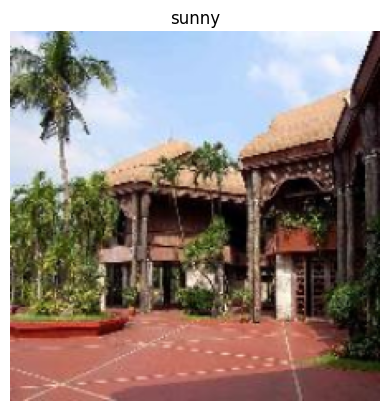

In [ ]:
image_permuted = image.permute(1, 2, 0)
plt.imshow(image_permuted)
plt.title(class_names[label])
plt.axis(False)

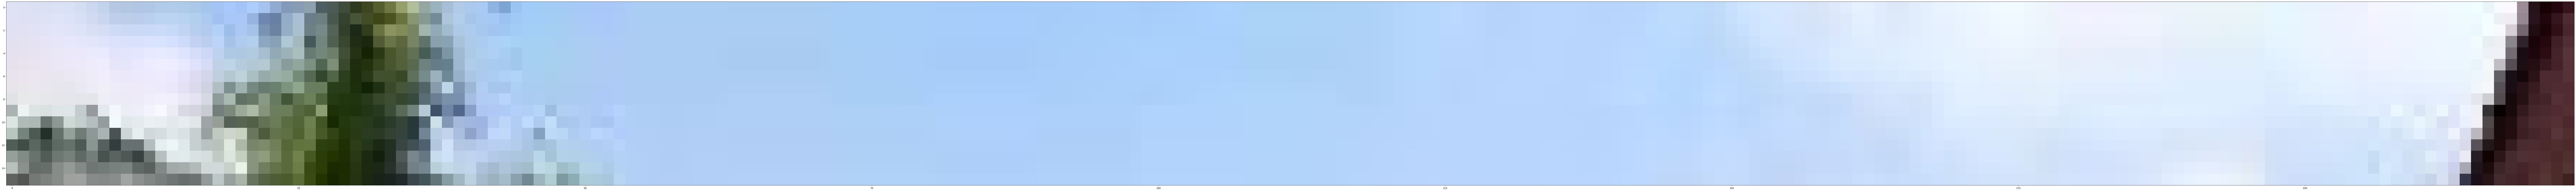

In [ ]:
# Top row
plt.figure(figsize=(N, P))
plt.imshow(image_permuted[:P, :, :])

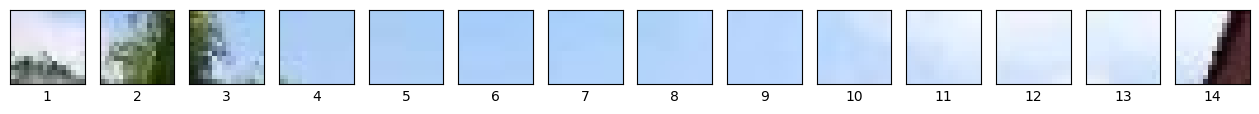

In [ ]:
# Plotting top row as patches
assert W % P == 0, "Image width must be divisible by the patch size."

fig, ax = plt.subplots(nrows=1,
                       ncols=W // P,
                       sharex=True,
                       sharey=True,
                       figsize=(P, P))

for i, p in enumerate(range(0, W, P)):
    ax[i].imshow(image_permuted[:P, p:p + P, :])
    ax[i].set_xlabel(i + 1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

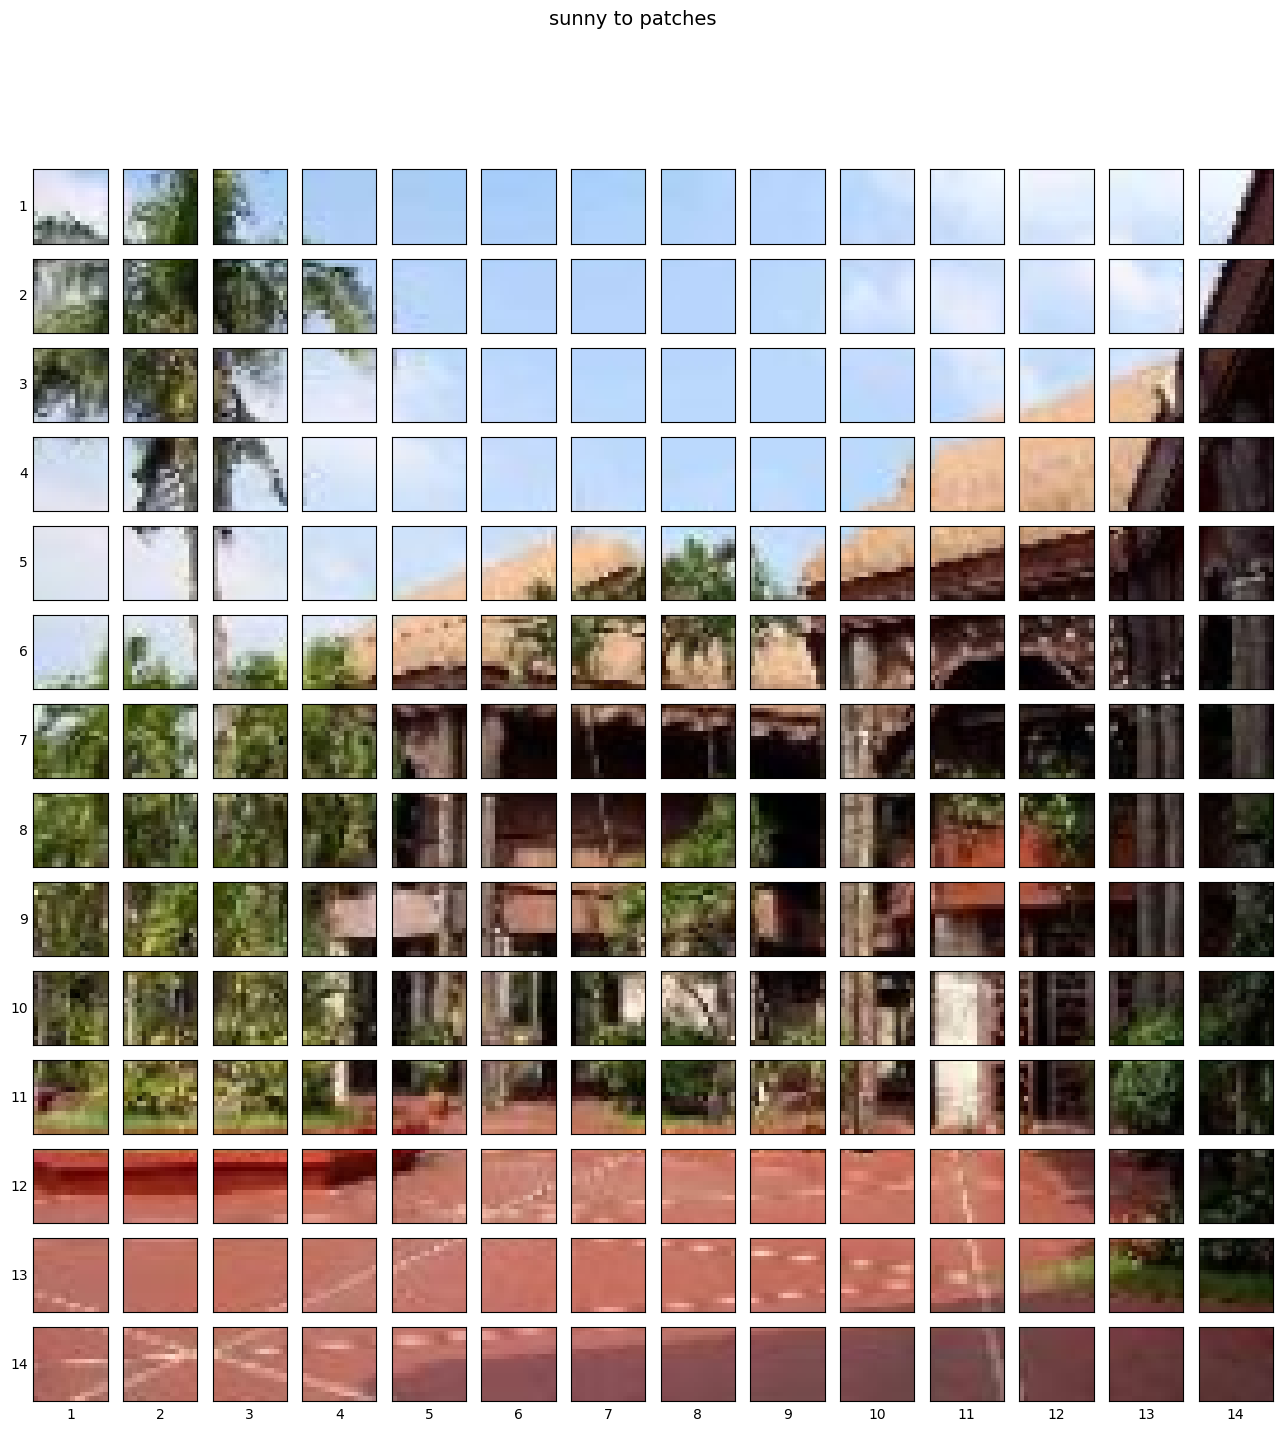

In [ ]:
# Plotting entire image as patches
assert H % P == 0, "Image height must be divisible by the patch size."
assert W % P == 0, "Image width must be divisible by the patch size."

fig, ax = plt.subplots(nrows=H // P,
                       ncols=W // P,
                       sharex=True,
                       sharey=True,
                       figsize=(P, P))

for i, r in enumerate(range(0, H, P)):
    for j, c in enumerate(range(0, W, P)):
        ax[i, j].imshow(image_permuted[r:r + P, c:c + P, :])
        ax[i, j].set_xlabel(j + 1)
        ax[i, j].set_ylabel(i + 1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].label_outer()

fig.suptitle(f"{class_names[label]} to patches", fontsize=14)
plt.show()

There are $14 \cdot 14 = 196$ patches, which matches $N$ as expected

$H \cdot W$ gives area of image, and $P \cdot P = P^2$ gives area of patch, so $N = \frac{A_{\text{image}}}{A_{\text{patch}}} = \frac{H \cdot W}{P^2}$

We will use a `nn.Conv2d` layer with `kernel_size = stride = P`

In [ ]:
conv2d_layer = nn.Conv2d(in_channels=3, # C
                   out_channels=768, # D
                   kernel_size=P,
                   stride=P,
                   padding=0)
conv2d_layer

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
image_from_conv2d_layer = conv2d_layer(image.unsqueeze(dim=0)) # batch dimension
image_from_conv2d_layer.shape

torch.Size([1, 768, 14, 14])

**Hybrid Architecture:**

- CNN: $D = 768$ feature maps over a $\sqrt{N} \times \sqrt{N} = 14 \times 14$ grid $\rightarrow$ $(B, D, \sqrt{N}, \sqrt{N}) = (B, 768, 14, 14)$
    - *Note:* `Conv2D` already does a patch extraction and linear projection so this is not necessary.
- ViT: 196 tokens that each describe one patch, as laid out in sequence, each with dimension $D$ features $\rightarrow$ $(B, N, D) = (B, 196, 768)$

In [ ]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=-1)
flatten_layer

Flatten(start_dim=2, end_dim=-1)

In [ ]:
image_after_flatten_layer = flatten_layer(image_from_conv2d_layer)
image_after_flatten_layer.shape

torch.Size([1, 768, 196])

In [ ]:
image_for_transformer_encoder = image_after_flatten_layer.permute(0, 2, 1)

In [ ]:
image_for_transformer_encoder.shape

torch.Size([1, 196, 768])

In [ ]:
# Get single flattened feature map
single_flattened_feature_map = image_for_transformer_encoder[:, 0, :] # one patch

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis(False)

(np.float64(-0.5), np.float64(767.5), np.float64(0.5), np.float64(-0.5))

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 C:int=3,
                 P:int=16,
                 D:int=768):
        super().__init__()

        self.C = C
        self.P = P
        self.D = D

        self.patcher = nn.Conv2d(in_channels=C,
                                 out_channels=D,
                                 kernel_size=P,
                                 stride=P)
        self.flatten = nn.Flatten(start_dim=2, end_dim=-1)

    def forward(self, x):
        assert x.shape[-1] % self.patcher.kernel_size[0] == 0, "Image height must be divisible by the patch size."
        assert x.shape[-2] % self.patcher.kernel_size[1] == 0, "Image width must be divisible by the patch size."

        x = self.patcher(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)
        return x

In [ ]:
set_seeds()
patch_embedding_layer = PatchEmbedding()
patch_embedding_layer

PatchEmbedding(
  (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (flatten): Flatten(start_dim=2, end_dim=-1)
)

In [ ]:
print(f"Input image shape: {image.unsqueeze(dim=0).shape}")
patch_embedding_image = patch_embedding_layer(image.unsqueeze(dim=0))
print(f"Output embedding shape: {patch_embedding_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output embedding shape: torch.Size([1, 196, 768])


In [ ]:
B = patch_embedding_image.shape[0]
D = patch_embedding_image.shape[-1]

### Class Token

Each token is $(B, 1, D)$, and we are adding one to the beginning of the $N = 196$ patch embedding tokens.

As a result the size is now $(B, N + 1, D)$

In [ ]:
class_token = nn.Parameter(torch.ones(B, 1, D), requires_grad=True) # using torch.ones for visualization of the the token's current location
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image_with_class_token = torch.cat((class_token, patch_embedding_image), dim=1) # dim = 1 is skipping number of patches dimension
patch_embedded_image_with_class_token.shape, patch_embedded_image_with_class_token

(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-1.0440,  0.2043,  0.0110,  ...,  0.6652, -0.3582,  0.1710],
          [-0.4239, -0.1726, -0.0624,  ...,  0.3241, -0.3799,  0.2675],
          ...,
          [-0.3535,  0.0264, -0.0683,  ...,  0.2350, -0.1792,  0.1158],
          [-0.3094,  0.0193, -0.0661,  ...,  0.1980, -0.1577,  0.1282],
          [-0.2822,  0.0142, -0.0719,  ...,  0.1812, -0.1336,  0.1168]]],
        grad_fn=<CatBackward0>))

### Position Embedding

In [ ]:
position_embedding = nn.Parameter(torch.ones(1, N + 1, D)) # once again using torch.ones for visualization of changes imposed
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
patch_and_position_embedding = patch_embedded_image_with_class_token + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
          [-0.0440,  1.2043,  1.0110,  ...,  1.6652,  0.6418,  1.1710],
          [ 0.5761,  0.8274,  0.9376,  ...,  1.3241,  0.6201,  1.2675],
          ...,
          [ 0.6465,  1.0264,  0.9317,  ...,  1.2350,  0.8208,  1.1158],
          [ 0.6906,  1.0193,  0.9339,  ...,  1.1980,  0.8423,  1.1282],
          [ 0.7178,  1.0142,  0.9281,  ...,  1.1812,  0.8664,  1.1168]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

### Image to Embedding

In [ ]:
# set seeds
set_seeds()

# set patch size and embedding dimension size
P = 16
D = 768

# print shapes of image tensor and dimensions
print(f"Image tensor shape: {image.shape}")
C, H, W = image.shape[0], image.shape[1], image.shape[2]

# get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# create patch embedding layer
patch_embedding_layer = PatchEmbedding(C=C, P=P, D=D)

# pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)

# create class token
B = patch_embedding.shape[0]
N = patch_embedding.shape[1]
class_token = nn.Parameter(torch.ones(B, 1, D), requires_grad=True)
print(f"Class token shape: {class_token.shape}")

# add class token to patch embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_with_class_token.shape}")

# create position embedding
position_embedding = nn.Parameter(torch.ones(B, N + 1, D))
print(f"Position embedding shape: {position_embedding.shape}")

# add position embedding to patch embedding
patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch embedding with class token and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch embedding with class token and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: The MSA Layer
As (self-)attention is about having a model look at every other token for each token to determine how much it should pay attention to them - find relationships between them.

In a similar manner, the patches are related to each other in attention in ViT.

Each token (patch) produces queries, keys, and values:
- Query $\rightarrow$ What am I looking for?
- Key $\rightarrow$ What do I have to offer?
- Value $\rightarrow$ What information do I carry?

In self-attention, the Query ($Q$), Key ($K$), and Value ($V$) vectors all originate from the same input sequence

Note the class token is special:
- It can attend to all patches
- It aggregates global information about the image

Layer Normalization: Applies Layer Normalization over a mini-batch of inputs. This layer normalization will be done over the embedding dimension $D$ (trailing dimension passed into LN)

- $h$: Number of heads

In [ ]:
class MSAModule(nn.Module):
    def __init__(self,
                 D:int=768,
                 h:int=12,
                 attn_dropout:int=0):
        super().__init__()

        self.D = D
        self.h = h
        self.attn_dropout = attn_dropout

        self.layer_norm = nn.LayerNorm(normalized_shape=D)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=D,
                                                    num_heads=h,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # We want (batch, sequence, feature) not (sequence, batch, feature)
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, attn_weights = self.multihead_attn(query=x,
                                                        key=x,
                                                        value=x,
                                                        need_weights=False)
        return attn_output

In [ ]:
h = 12
attn_dropout = 0

msa_module = MSAModule(D=D,
                     h=h,
                     attn_dropout=attn_dropout)

patched_image_after_msa_module = msa_module(patch_and_position_embedding)
print(f"Patched image after MSA layer shape: {patched_image_after_msa_module.shape}")
print(f"patch_and_position_embedding: {patch_and_position_embedding.shape}")

Patched image after MSA layer shape: torch.Size([1, 197, 768])
patch_and_position_embedding: torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding, patched_image_after_msa_module

(tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
          [-0.0440,  1.2043,  1.0110,  ...,  1.6652,  0.6418,  1.1710],
          [ 0.5761,  0.8274,  0.9376,  ...,  1.3241,  0.6201,  1.2675],
          ...,
          [ 0.6465,  1.0264,  0.9317,  ...,  1.2350,  0.8208,  1.1158],
          [ 0.6906,  1.0193,  0.9339,  ...,  1.1980,  0.8423,  1.1282],
          [ 0.7178,  1.0142,  0.9281,  ...,  1.1812,  0.8664,  1.1168]]],
        grad_fn=<AddBackward0>),
 tensor([[[-0.2242, -0.1840,  0.0603,  ..., -0.4393,  0.8970, -0.4692],
          [-0.2242, -0.1711,  0.0631,  ..., -0.4358,  0.9068, -0.4940],
          [-0.2207, -0.1660,  0.0601,  ..., -0.4413,  0.9061, -0.4927],
          ...,
          [-0.2252, -0.1720,  0.0606,  ..., -0.4303,  0.9047, -0.4942],
          [-0.2260, -0.1729,  0.0618,  ..., -0.4292,  0.9054, -0.4940],
          [-0.2263, -0.1728,  0.0610,  ..., -0.4287,  0.9055, -0.4941]]],
        grad_fn=<TransposeBackward0>))

## Equation 3: The MLP Layer

The **MLP layer** contains two `Linear` layers with a GELU non-linearity (activation) in between (section 3.1)

Number of hidden units is defined as MLP size in Table 1.

```python
# MLP
x -> Linear(D->mlp_size) -> GELU -> Dropout -> Linear(mlp_size->D) -> Dropout -> output
```

*Note:* We can set `mlp_size`$=4D$ as that seems to scale in the paper, however we will use absolute numbers in this case.

In [ ]:
class MLPModule(nn.Module):
    def __init__(self,
                 D:int=768,
                 mlp_size:int=3072,
                 dropout:int=0.1):

        super().__init__()

        self.D = D
        self.mlp_size = mlp_size
        self.dropout = dropout

        self.layer_norm = nn.LayerNorm(normalized_shape=D)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=D,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=D),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
mlp_size = 3072 # 4 * D
mlp_dropout = 0.1

mlp_module = MLPModule(D=D,
                     mlp_size=mlp_size,
                     dropout=mlp_dropout)

patched_image_after_mlp_module = mlp_module(patched_image_after_msa_module)
print(f"Patched image after MLP module shape: {patched_image_after_mlp_module.shape}")

Patched image after MLP module shape: torch.Size([1, 197, 768])


In [ ]:
patched_image_after_msa_module, patched_image_after_mlp_module

(tensor([[[-0.2242, -0.1840,  0.0603,  ..., -0.4393,  0.8970, -0.4692],
          [-0.2242, -0.1711,  0.0631,  ..., -0.4358,  0.9068, -0.4940],
          [-0.2207, -0.1660,  0.0601,  ..., -0.4413,  0.9061, -0.4927],
          ...,
          [-0.2252, -0.1720,  0.0606,  ..., -0.4303,  0.9047, -0.4942],
          [-0.2260, -0.1729,  0.0618,  ..., -0.4292,  0.9054, -0.4940],
          [-0.2263, -0.1728,  0.0610,  ..., -0.4287,  0.9055, -0.4941]]],
        grad_fn=<TransposeBackward0>),
 tensor([[[-0.0894, -0.0118,  0.2254,  ..., -0.0130, -0.1058,  0.2954],
          [-0.0411,  0.0129,  0.1912,  ..., -0.0000, -0.1253,  0.2568],
          [-0.0694, -0.0664,  0.1449,  ..., -0.0322, -0.1884,  0.3264],
          ...,
          [-0.0604, -0.0903,  0.1609,  ...,  0.0671, -0.1611,  0.1483],
          [-0.1017, -0.0000,  0.1275,  ...,  0.1579, -0.1804,  0.2389],
          [-0.1342, -0.0174,  0.0791,  ...,  0.1028, -0.0295,  0.2704]]],
        grad_fn=<MulBackward0>))

## The Transformer Encoder Block

The Transformer Encoder Block is a combination of alternating MSA (Equation 2) and MLP (Equation 3) modules. There are residual connections between each block.

- Encoder: Turn a sequence into a learnable representation (Embedding)
- Decoder: Turn a learnable representation back into a sequence
- Residual connections: Add layer input into its subsequent output, which enables the creation of deeper networks (prevents weights getting too small)

### Custom Transformer Encoder

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 D:int=768,
                 h:int=12,
                 attn_dropout:int=0.1,
                 mlp_size:int=3072,
                 mlp_dropout:int=0.1):

        super().__init__()

        self.D = D
        self.h = h
        self.attn_dropout = attn_dropout
        self.mlp_size = mlp_size
        self.mlp_dropout = mlp_dropout

        self.msa_module = MSAModule(D=D,
                                    h=h,
                                    attn_dropout=attn_dropout)

        self.mlp_module = MLPModule(D=D,
                                mlp_size=mlp_size,
                                dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_module(x) + x # residual connections (technically can be written in the block as well)
        x = self.mlp_module(x) + x
        return x

In [ ]:
transformer_encoder_block = TransformerEncoderBlock(D=D,
                                                    h=h,
                                                    attn_dropout=attn_dropout,
                                                    mlp_size=mlp_size,
                                                    mlp_dropout=mlp_dropout)

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) # torchinfo

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MSAModule (msa_module)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPModule (mlp_module)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Transformer Encoder with PyTorch layers
A single Transformer Encoder block is implemented as a `nn.TransformEncoderLayer` in PyTorch.

*Note:* It may be faster and more optimized than the custom transformer encoder block.

*Note:* It does not have separate dropouts for MLP and MSA.

In [ ]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=D,
                                                             nhead=h,
                                                             dropout=mlp_dropout, # note that this applies to both MSA and MLP! So our custom one is more flexible and true to the ViT paper
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True # LN before the MA or MLP (pre-LN)
                                                             )
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) # torchinfo

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 2048]       1,574,912            True
├─Dropout (dropout)                                [1, 197, 2048]       [1, 197, 2048]       --                   --
├─Linear (linear2)                             

## Creating the ViT Model

In [ ]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224, # Table 3 from the ViT paper
                 W:int=224,
                 P:int=16,
                 L:int=12, # Table 1 for "Layers" for ViT-Base --> Number of Transformer Encoder layers
                 D:int=768, # Table 1 for "Hidden Size"
                 mlp_size:int=3072,
                 h:int=12,
                 attn_dropout:int=0.1,
                 mlp_dropout:int=0.1,
                 embedding_dropout:int=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000 # 5 for our problem, 1000 for ImageNet1K
                 ):

        super().__init__()

        self.img_size = img_size
        self.W = W
        self.P = P
        self.L = L
        self.D = D
        self.mlp_size = mlp_size
        self.h = h
        self.attn_dropout = attn_dropout
        self.mlp_dropout = mlp_dropout
        self.embedding_dropout = embedding_dropout
        self.num_classes = num_classes

        self.H, self.W = img_size, img_size
        self.N = (self.H * self.W) // (self.P ** 2)

        assert img_size % P == 0, f"Image size must be divisible by patch size: Image: {img_size}, patch: {P}"

        # learnable class embedding
        self.class_token = nn.Parameter(torch.randn(1, 1, D), requires_grad=True) # batch size is determined at runtime, will be expanded to (B, 1, D)

        # learable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.N + 1, self.D))

        # embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # patch embedding layer
        self.patch_embedding_layer = PatchEmbedding(C=C,
                                                    P=P,
                                                    D=D)

        # transformer encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(D=D,
                                                                           h=h,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(L)]) # list comprehention with unpacking

        # classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=D),
            nn.Linear(in_features=D,
                      out_features=num_classes)
        )

    def forward(self, x):
        B = x.shape[0]

        # get embedded patches
        x = self.patch_embedding_layer(x)

        # expand class tokens to match batch size
        class_tokens = self.class_token.expand(B, -1, -1)
        # prepend class token
        x = torch.cat((class_tokens, x), dim=1)

        # expand position embeddings to match batch size
        position_embeddings = self.position_embedding.expand(B, -1, -1)
        # add position embeddings
        x = x + position_embeddings

        # embedding dropout
        x = self.embedding_dropout(x)

        # transformer encoder stack
        x = self.transformer_encoder(x)

        # classifier head
        x = self.classifier(x[:, 0]) # classifier head only (select all batches)

        return x

In [ ]:
set_seeds()

vit = ViT(num_classes=len(class_names))
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding_layer): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=-1)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_module): MSAModule(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_module): MLPModule(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): T

In [ ]:
summary(model=vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) # torchinfo

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 5]               152,064              True
├─PatchEmbedding (patch_embedding_layer)                     [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

### Pretrained ViT
Looking at the pretrained ViT model from PyTorch, the number of parameters is $85,802,501$, which is the same as the custom-built replicated model.

In [ ]:
# get pretrained weights and setup a ViT model instance with them
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # DEFAULT is best available
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# freeze base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [ ]:
# update classifier head
set_seeds()
pretrained_vit.heads.head = torch.nn.Linear(
    in_features=D,
    out_features=len(class_names)
)

In [ ]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) # torchinfo

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 5]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Testing ViT on Weather Image Data

### Creating the optimizer

As in the ViT paper, the Adam optimizer will be used, with $\beta_1 = 0.9$ and $\beta_2 = 0.999$, and weight decay being $0.1$.

Weight decay is a regularization technique by adding a small penality to the loss function which prevents overfitting.

For ViT-B/16, the learning rate is $10^{-3}$.

In [ ]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### Creating a loss function
The ViT paper does not mention the loss function used, however it is a classification problem so we will use `nn.CrossEntropyLoss()`.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

### Training and testing ViT

The model is trained from scratch without pre-training or transfer learning, so the results will be limited compared to the original paper.

**Key Differences from the Original ViT Paper Training:**

**Dataset:**
- Using thousands of images instead of millions (ImageNet-21K has 14M images)
- No pre-training on large-scale datasets
- Training from scratch on a small weather dataset

**Missing Training Techniques:**
- **Learning rate warmup:** Gradually increasing learning rate from low to target value at the start of training
- **Learning rate decay:** Reducing learning rate as training progresses toward convergence
- **Gradient clipping:** Preventing exploding gradients by capping their maximum value

*Note:* For better results, use a pretrained model from `torchvision.models` and fine-tune it with transfer learning on the weather dataset.


In [ ]:
NUM_EPOCHS = 10

results = train(model=vit,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=NUM_EPOCHS,
      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4034 | train_acc: 0.3648 | test_loss: 1.4016 | test_acc: 0.3487
Epoch: 2 | train_loss: 1.3987 | train_acc: 0.3615 | test_loss: 1.3958 | test_acc: 0.3487
Epoch: 3 | train_loss: 1.3995 | train_acc: 0.3697 | test_loss: 1.4003 | test_acc: 0.3487
Epoch: 4 | train_loss: 1.3992 | train_acc: 0.3692 | test_loss: 1.3960 | test_acc: 0.3487
Epoch: 5 | train_loss: 1.3994 | train_acc: 0.3667 | test_loss: 1.3999 | test_acc: 0.3709
Epoch: 6 | train_loss: 1.3990 | train_acc: 0.3673 | test_loss: 1.3954 | test_acc: 0.3709
Epoch: 7 | train_loss: 1.3983 | train_acc: 0.3701 | test_loss: 1.3967 | test_acc: 0.3487
Epoch: 8 | train_loss: 1.3980 | train_acc: 0.3659 | test_loss: 1.3977 | test_acc: 0.3709
Epoch: 9 | train_loss: 1.3990 | train_acc: 0.3706 | test_loss: 1.3961 | test_acc: 0.3709
Epoch: 10 | train_loss: 1.3992 | train_acc: 0.3699 | test_loss: 1.3955 | test_acc: 0.3709


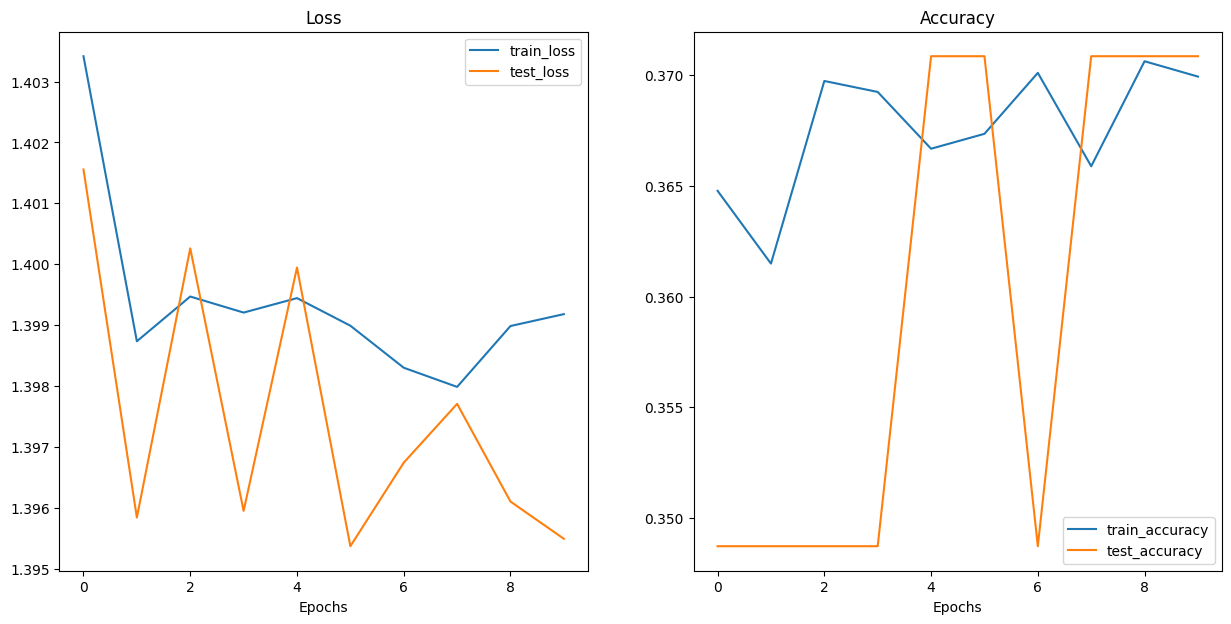

In [ ]:
plot_loss_curves(results=results)

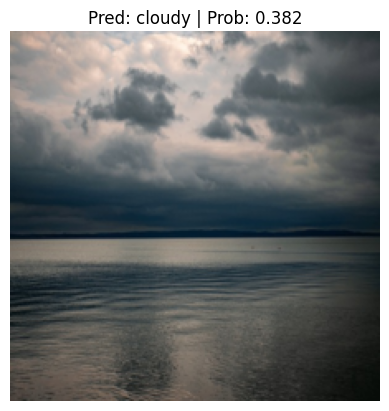

In [ ]:
custom_image_source = "https://www.shutterstock.com/image-photo/dramatic-cloudy-sky-over-calm-600nw-2688634011.jpg"
custom_image_dest = "/content/custom_images/cloudy.jpg"

custom_image_dest = download_image(source=custom_image_source,
               dest=custom_image_dest)

pred_and_plot_image(model=vit,
                    image_path=custom_image_dest,
                    class_names=class_names,
                    transform=manual_transforms,
                    device=device)

### Saving the ViT model

In [ ]:
filename = "vit_weather"
save_model(model=vit,
           target_dir="/content/models",
           model_name=f"{filename}.pth")

[INFO] Saving model to: /content/models/vit_weather.pth


In [ ]:
from pathlib import Path
vit_model_size = Path(f"/content/models/{filename}.pth").stat().st_size // (1024**2)
print(f"ViT model size: {vit_model_size} MB")

ViT model size: 327 MB
